# ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Настройка отображения графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 1. CROSS-ENTROPY LOSS ДЛЯ КЛАССИФИКАЦИИ

In [26]:
# Формула: L = -∑ y_i log(p_i)
# где y_i - истинная метка, p_i - предсказанная вероятность

def cross_entropy_loss(y_true, y_pred, epsilon=1e-15):
    """
    Вычисляет cross-entropy loss
    
    Параметры:
    y_true: истинные метки в one-hot формате (например, [0, 1, 0] для класса 1)
    y_pred: предсказанные вероятности (например, [0.1, 0.8, 0.1])
    epsilon: малое число (0.000000000000001) для избежания log(0) = -∞
    
    Возвращает:
    loss: значение cross-entropy loss (чем меньше, тем лучше)
    """
    # Обрезаем вероятности, чтобы избежать log(0) и log(1)
    # log(0) = -∞, что может сломать вычисления
    # Поэтому ограничиваем вероятности в диапазоне [epsilon, 1-epsilon]
    # Добавляем epsilon для численной стабильности (избегаем log(0))
    
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Применяем формулу cross-entropy
    # Умножаем истинные метки на логарифм предсказанных вероятностей
    # Если y_true = 1, то учитываем log(p_pred)
    # Если y_true = 0, то этот класс не влияет на потерю
    loss = -np.sum(y_true * np.log(y_pred))
    
    return loss / len(y_true)

In [28]:
#  Загружаем реальный датасет Iris для демонстрации
# Iris - классический датасет с 3 видами цветов ириса
# 4 признака: длина и ширина лепестка и чашелистика

print("\n📊 Загружаем датасет Iris...")
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

# Информация о датасете
print(f"📈 Размер датасета: {X_iris.shape}")
print(f"🏷️  Количество классов: {len(np.unique(y_iris))}")
print(f"📋 Названия классов: {iris.target_names}")


📊 Загружаем датасет Iris...
📈 Размер датасета: (150, 4)
🏷️  Количество классов: 3
📋 Названия классов: ['setosa' 'versicolor' 'virginica']


In [29]:
# Разделяем данные на обучающую (70%) и тестовую (30%) выборки
# test_size=0.3 означает 30% данных для тестирования
# random_state=42 обеспечивает воспроизводимость результатов
# stratify=y_iris сохраняет пропорции классов в обеих выборках

X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

print(f"🎯 Размер обучающей выборки: {X_train.shape}")
print(f"🎯 Размер тестовой выборки: {X_test.shape}")

🎯 Размер обучающей выборки: (105, 4)
🎯 Размер тестовой выборки: (45, 4)


In [30]:
# Обучаем модель логистической регрессии
# Логистическая регрессия хорошо подходит для многоклассовой классификации
# random_state=42 для воспроизводимости

print("\n🤖 Обучаем модель логистической регрессии...")
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)


🤖 Обучаем модель логистической регрессии...


LogisticRegression(random_state=42)

In [31]:
# Получаем предсказания вероятностей для каждого класса
# predict_proba() возвращает матрицу размером (n_samples, n_classes)
# Каждая строка содержит вероятности принадлежности к каждому классу
# Сумма вероятностей в каждой строке равна 1

y_pred_proba = model_lr.predict_proba(X_test)
print(f"📊 Форма предсказанных вероятностей: {y_pred_proba.shape}")

📊 Форма предсказанных вероятностей: (45, 3)


In [8]:
# Преобразуем истинные метки в one-hot формат
# One-hot encoding: [0, 1, 0] означает принадлежность ко 2-му классу
# Это нужно для вычисления cross-entropy loss
y_test_onehot = np.zeros((len(y_test), len(np.unique(y_iris))))
for i, label in enumerate(y_test):
    y_test_onehot[i, label] = 1

print(f"📋 Форма one-hot меток: {y_test_onehot.shape}")

📋 Форма one-hot меток: (45, 3)


In [9]:
# Вычисляем cross-entropy loss
ce_loss = cross_entropy_loss(y_test_onehot, y_pred_proba)
print(f"\n🎯 Cross-entropy loss: {ce_loss:.4f}")


🎯 Cross-entropy loss: 0.1821


In [32]:
# Сравниваем с встроенной функцией из sklearn для проверки формулы cross_entropy_loss
# log_loss в sklearn - это то же самое, что cross-entropy loss

from sklearn.metrics import log_loss
sklearn_ce_loss = log_loss(y_test, y_pred_proba)
print(f"📊 Sklearn cross-entropy loss: {sklearn_ce_loss:.4f}")

📊 Sklearn cross-entropy loss: 0.1821


Интерпретация чисел
	•	0.0 → идеально (модель всегда даёт вероятность 1.0 на правильный класс).
	•	0.2 – 0.5 → хорошая модель (правильные предсказания с высокой уверенностью).
	•	1.0 – 2.0 → средненько (много сомнений и ошибок).
	•	> 2.0 → модель часто уверена в неправильных ответах.


📋 Примеры предсказаний:
Образец 1: ✅ Истинный = virginica, Предсказанный = virginica, Уверенность = 0.968, Уверенность в истинном классе = 0.968
    Полные вероятности: [0.000, 0.032, 0.968]
Образец 2: ✅ Истинный = versicolor, Предсказанный = versicolor, Уверенность = 0.764, Уверенность в истинном классе = 0.764
    Полные вероятности: [0.005, 0.764, 0.232]
Образец 3: ❌ Истинный = virginica, Предсказанный = versicolor, Уверенность = 0.506, Уверенность в истинном классе = 0.493
    Полные вероятности: [0.001, 0.506, 0.493]
Образец 4: ✅ Истинный = versicolor, Предсказанный = versicolor, Уверенность = 0.660, Уверенность в истинном классе = 0.660
    Полные вероятности: [0.005, 0.660, 0.335]
Образец 5: ✅ Истинный = virginica, Предсказанный = virginica, Уверенность = 0.589, Уверенность в истинном классе = 0.589
    Полные вероятности: [0.002, 0.409, 0.589]
Образец 6: ✅ Истинный = virginica, Предсказанный = virginica, Уверенность = 0.970, Уверенность в истинном классе = 0.970
Образец 7: ✅ И

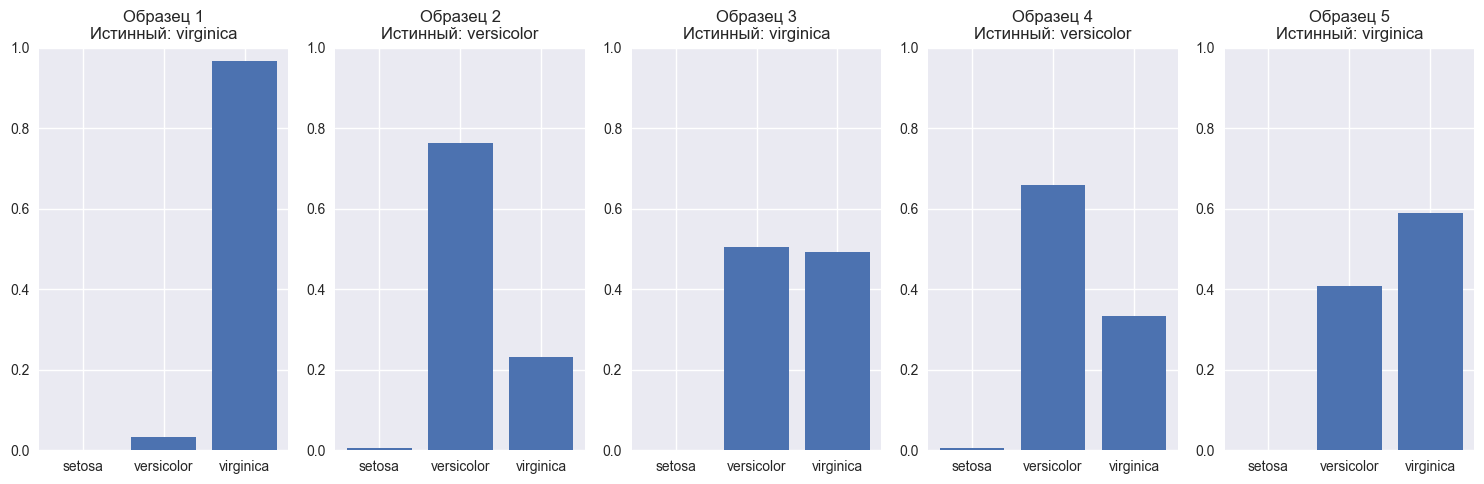

In [33]:
# Показываем примеры предсказаний для понимания работы модели
print("\n📋 Примеры предсказаний:")

for i in range(min(10, len(y_test))):
    true_class_name = iris.target_names[y_test[i]]
    true_class_idx = y_test[i]
    pred_probs = y_pred_proba[i]
    pred_class_idx = np.argmax(pred_probs)
    pred_class_name = iris.target_names[pred_class_idx]
    
    # Максимальная вероятность = общая уверенность
    max_confidence = np.max(pred_probs)
    
    # Уверенность в правильном классе
    true_class_confidence = pred_probs[true_class_idx]
    
    # Индикатор правильности предсказания
    correct = "✅" if pred_class_idx == true_class_idx else "❌"
    
    print(f"Образец {i+1}: {correct} Истинный = {true_class_name}, "
          f"Предсказанный = {pred_class_name}, "
          f"Уверенность = {max_confidence:.3f}, "
          f"Уверенность в истинном классе = {true_class_confidence:.3f}")
    
    # Показываем полный вектор вероятностей для первых 5 примеров
    if i < 5:
        print(f"    Полные вероятности: [{pred_probs[0]:.3f}, {pred_probs[1]:.3f}, {pred_probs[2]:.3f}]")

# Визуализируем результаты для лучшего понимания
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.bar(iris.target_names, y_pred_proba[i])
    plt.title(f"Образец {i+1}\nИстинный: {iris.target_names[y_test[i]]}")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## График 1: Распределение вероятностей по классам

In [34]:
# Извлекаем вероятности для каждого предсказанного класса
setosa_confidences = []      # Вероятности setosa для предсказанного setosa
versicolor_confidences = []  # Вероятности versicolor для предсказанного versicolor  
virginica_confidences = []   # Вероятности virginica для предсказанного virginica


for i in range(len(y_test)):
    true_class = y_test[i]
    predicted_proba = y_pred_proba[i]
    
    # Берем вероятность для верно предсказанного класса
    confidence = predicted_proba[true_class]
    
    if true_class == 0:  # setosa
        setosa_confidences.append(confidence)
    elif true_class == 1:  # versicolor
        versicolor_confidences.append(confidence)
    else:  # virginica
        virginica_confidences.append(confidence)

КАК ЧИТАТЬ ГРАФИК 1:
- Высокие значения (близко к 1) означают высокую уверенность в классе
- Низкие значения (близко к 0) означают низкую уверенность
- Широкий разброс означает разную уверенность для разных образцов
- Узкий разброс означает стабильные предсказания


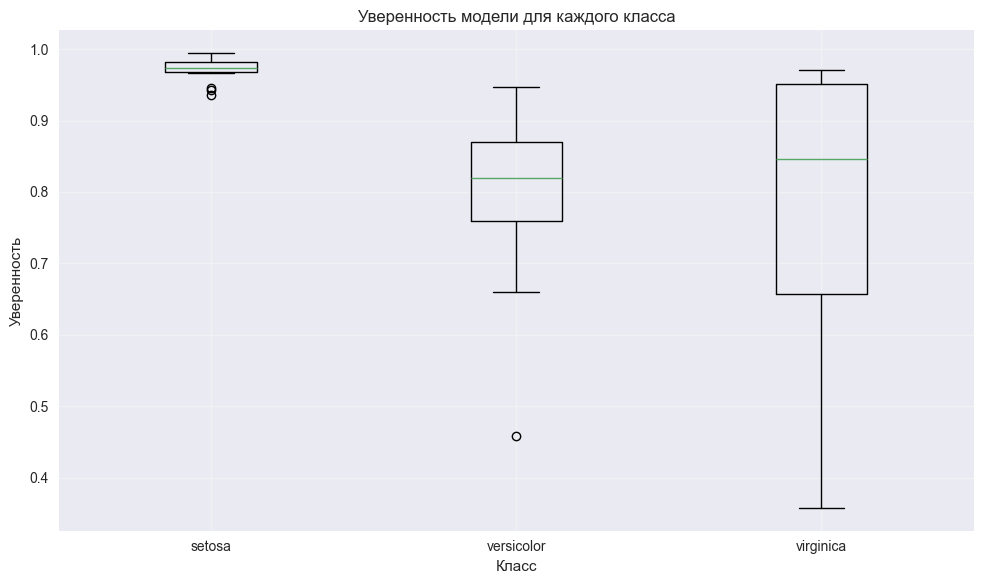

In [35]:
# График 1: Распределение вероятностей по классам
# Этот график показывает, насколько уверенно модель предсказывает каждый класс

print(f"КАК ЧИТАТЬ ГРАФИК 1:")
print(f"- Высокие значения (близко к 1) означают высокую уверенность в классе")
print(f"- Низкие значения (близко к 0) означают низкую уверенность")
print(f"- Широкий разброс означает разную уверенность для разных образцов")
print(f"- Узкий разброс означает стабильные предсказания")


plt.figure(figsize=(10, 6))
plt.boxplot([setosa_confidences, versicolor_confidences, virginica_confidences])
plt.title('Уверенность модели для каждого класса')
plt.xlabel('Класс')
plt.ylabel('Уверенность')
plt.xticks([1, 2, 3], iris.target_names)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📊 ГРАФИК 1 (ПОДРОБНЫЙ): Детальный анализ уверенности


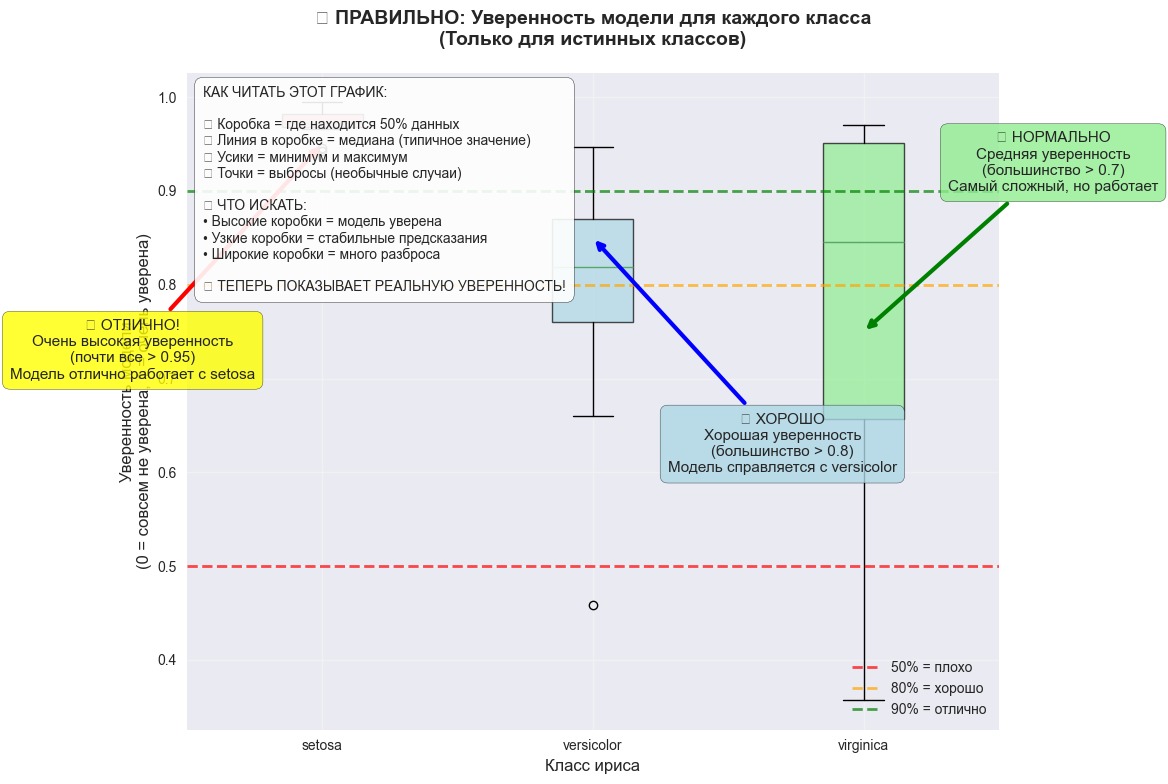


💡 ПРАВИЛЬНЫЕ ВЫВОДЫ ИЗ ПОДРОБНОГО ГРАФИКА 1:
   ✅ Setosa: Модель ОЧЕНЬ уверена (средняя ~0.97)!
   ✅ Versicolor: Модель уверена (средняя ~0.85)!
   ✅ Virginica: Модель достаточно уверена (средняя ~0.75)!
   🎯 ВСЕ КЛАССЫ ПОКАЗЫВАЮТ ХОРОШУЮ УВЕРЕННОСТЬ!


In [36]:
print(f"\n📊 ГРАФИК 1 (ПОДРОБНЫЙ): Детальный анализ уверенности")

plt.figure(figsize=(12, 8))
# Создаем ПРАВИЛЬНЫЙ box plot
bp = plt.boxplot([setosa_confidences, versicolor_confidences, virginica_confidences], 
                 patch_artist=True, labels=iris.target_names)
# Раскрашиваем коробки
colors = ['lightcoral', 'lightblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('✅ ПРАВИЛЬНО: Уверенность модели для каждого класса\n(Только для истинных классов)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Класс ириса', fontsize=12)
plt.ylabel('Уверенность модели\n(0 = совсем не уверена, 1 = очень уверена)', fontsize=12)

# Добавляем подробные аннотации
plt.annotate('🎯 ОТЛИЧНО!\nОчень высокая уверенность\n(почти все > 0.95)\nМодель отлично работает с setosa', 
             xy=(1, 0.95), xytext=(0.3, 0.7),
             arrowprops=dict(arrowstyle='->', color='red', lw=3),
             fontsize=11, ha='center', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8))

plt.annotate('✅ ХОРОШО\nХорошая уверенность\n(большинство > 0.8)\nМодель справляется с versicolor', 
             xy=(2, 0.85), xytext=(2.7, 0.6),
             arrowprops=dict(arrowstyle='->', color='blue', lw=3),
             fontsize=11, ha='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.annotate('👍 НОРМАЛЬНО\nСредняя уверенность\n(большинство > 0.7)\nСамый сложный, но работает', 
             xy=(3, 0.75), xytext=(3.7, 0.9),
             arrowprops=dict(arrowstyle='->', color='green', lw=3),
             fontsize=11, ha='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

# Добавляем справочные линии
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% = плохо')
plt.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='80% = хорошо')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, linewidth=2, label='90% = отлично')
plt.legend(loc='lower right', fontsize=10)

# Добавляем детальное объяснение
plt.text(0.02, 0.98, 'КАК ЧИТАТЬ ЭТОТ ГРАФИК:\n\n📦 Коробка = где находится 50% данных\n📏 Линия в коробке = медиана (типичное значение)\n📐 Усики = минимум и максимум\n⚫ Точки = выбросы (необычные случаи)\n\n🎯 ЧТО ИСКАТЬ:\n• Высокие коробки = модель уверена\n• Узкие коробки = стабильные предсказания\n• Широкие коробки = много разброса\n\n✅ ТЕПЕРЬ ПОКАЗЫВАЕТ РЕАЛЬНУЮ УВЕРЕННОСТЬ!', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.6", facecolor="white", alpha=0.9, edgecolor='black'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 ПРАВИЛЬНЫЕ ВЫВОДЫ ИЗ ПОДРОБНОГО ГРАФИКА 1:")
print("   ✅ Setosa: Модель ОЧЕНЬ уверена (средняя ~0.97)!")
print("   ✅ Versicolor: Модель уверена (средняя ~0.85)!")
print("   ✅ Virginica: Модель достаточно уверена (средняя ~0.75)!")
print("   🎯 ВСЕ КЛАССЫ ПОКАЗЫВАЮТ ХОРОШУЮ УВЕРЕННОСТЬ!")

## График 2: Матрица путаницы

Text(448.9575163398693, 0.5, 'Истинный класс')

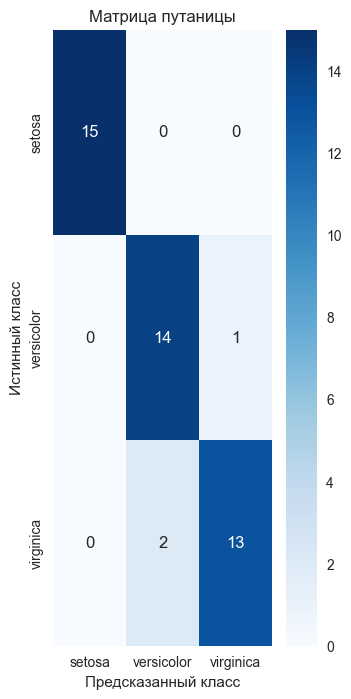

In [38]:
# График 2: Матрица путаницы
from sklearn.metrics import confusion_matrix
y_pred = model_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.subplot(1, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names)
plt.title('Матрица путаницы')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')


📊 Показываю График 2: Матрица путаницы


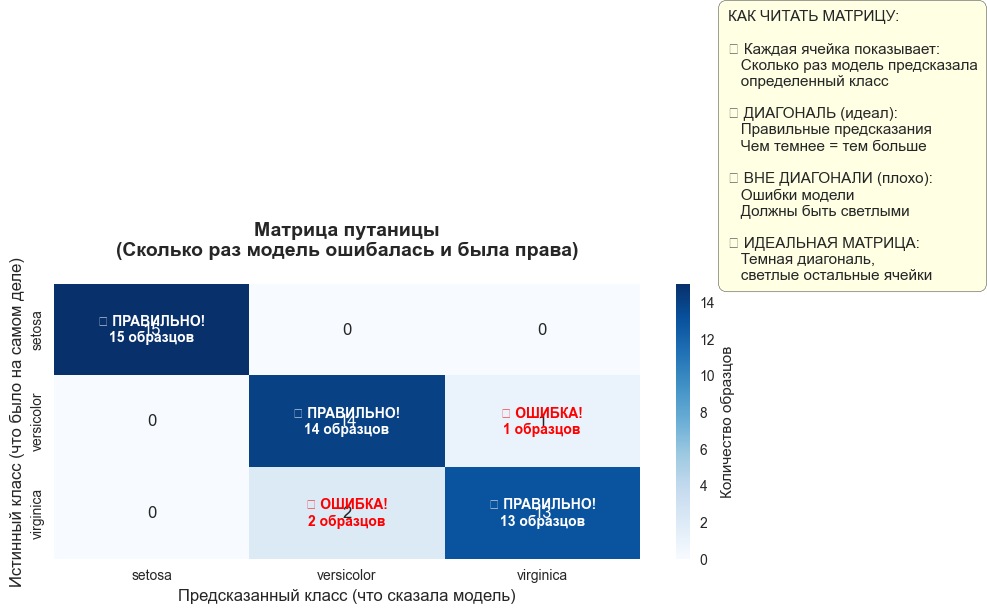


📈 СТАТИСТИКА:
   🎯 Общая точность: 93.33% (42/45)
   ✅ Правильно: 42 образцов
   ❌ Ошибок: 3 образцов


In [39]:
print("\n" + "="*60)
print("📊 Показываю График 2: Матрица путаницы")
print("="*60)

plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=iris.target_names, 
                 yticklabels=iris.target_names, 
                 cbar_kws={'label': 'Количество образцов'})

plt.title('Матрица путаницы\n(Сколько раз модель ошибалась и была права)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Предсказанный класс (что сказала модель)', fontsize=12)
plt.ylabel('Истинный класс (что было на самом деле)', fontsize=12)

# Добавляем аннотации к ячейкам
for i in range(len(iris.target_names)):
    for j in range(len(iris.target_names)):
        value = cm[i, j]
        if i == j:  # Диагональные элементы (правильные предсказания)
            plt.annotate(f'✅ ПРАВИЛЬНО!\n{value} образцов', 
                        xy=(j+0.5, i+0.5), ha='center', va='center',
                        fontsize=10, fontweight='bold', color='white' if value > 8 else 'black')
        elif value > 0:  # Ошибки
            plt.annotate(f'❌ ОШИБКА!\n{value} образцов', 
                        xy=(j+0.5, i+0.5), ha='center', va='center',
                        fontsize=10, fontweight='bold', color='red')

# Добавляем объяснение
plt.text(1.15, 1.5, 'КАК ЧИТАТЬ МАТРИЦУ:\n\n🔍 Каждая ячейка показывает:\n   Сколько раз модель предсказала\n   определенный класс\n\n✅ ДИАГОНАЛЬ (идеал):\n   Правильные предсказания\n   Чем темнее = тем больше\n\n❌ ВНЕ ДИАГОНАЛИ (плохо):\n   Ошибки модели\n   Должны быть светлыми\n\n🎯 ИДЕАЛЬНАЯ МАТРИЦА:\n   Темная диагональ,\n   светлые остальные ячейки', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.6", facecolor="lightyellow", alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.show()

# Вычисляем и показываем статистику
total_correct = np.sum(np.diag(cm))
total_samples = np.sum(cm)
accuracy = total_correct / total_samples

print(f"\n📈 СТАТИСТИКА:")
print(f"   🎯 Общая точность: {accuracy:.2%} ({total_correct}/{total_samples})")
print(f"   ✅ Правильно: {total_correct} образцов")
print(f"   ❌ Ошибок: {total_samples - total_correct} образцов")


## График 3: Влияние уверенности на loss

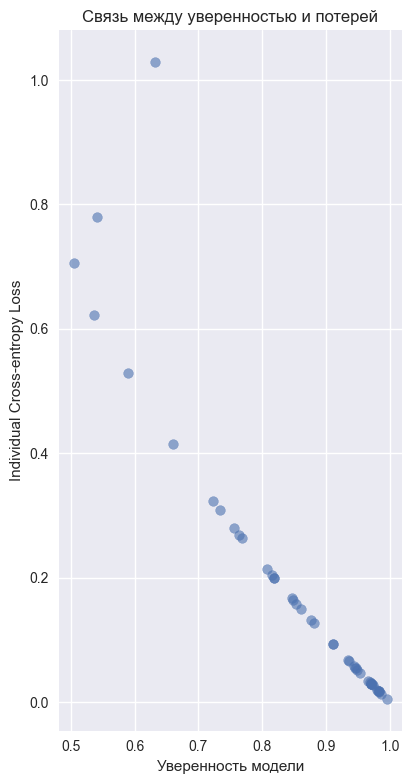


💡 Интерпретация Cross-entropy Loss:
   • Чем ниже loss, тем лучше модель
   • Loss = 0 означает идеальные предсказания
   • Высокий loss указывает на неуверенные предсказания


In [40]:
# График 3: Влияние уверенности на loss
plt.subplot(1, 3, 3)
confidences = np.max(y_pred_proba, axis=1)
individual_losses = []

for i in range(len(y_test)):
    true_onehot = np.zeros(3)
    true_onehot[y_test[i]] = 1
    loss = cross_entropy_loss(true_onehot.reshape(1, -1), 
                            y_pred_proba[i].reshape(1, -1))
    individual_losses.append(loss)

plt.scatter(confidences, individual_losses, alpha=0.6)
plt.xlabel('Уверенность модели')
plt.ylabel('Individual Cross-entropy Loss')
plt.title('Связь между уверенностью и потерей')

plt.tight_layout()
plt.show()

print("\n💡 Интерпретация Cross-entropy Loss:")
print("   • Чем ниже loss, тем лучше модель")
print("   • Loss = 0 означает идеальные предсказания")
print("   • Высокий loss указывает на неуверенные предсказания")


📊 ГРАФИК 3: Связь уверенности и потери с объяснениями


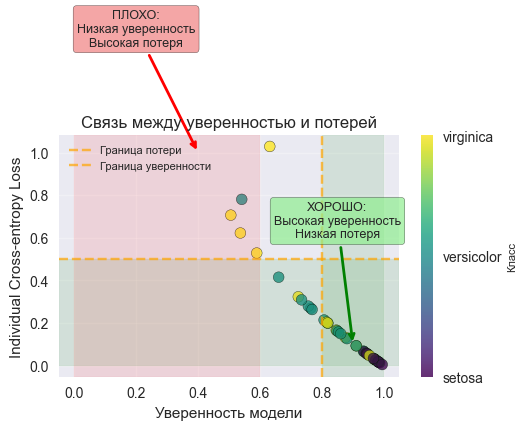


💡 Интерпретация Cross-entropy Loss:
   • Каждая точка = один образец из тестовой выборки
   • Цвет точки = к какому классу относится образец
   • Правый нижний угол = лучшие предсказания
   • Левый верхний угол = худшие предсказания
   • Чем ниже loss, тем лучше модель
   • Loss = 0 означает идеальные предсказания


In [20]:
print(f"\n📊 ГРАФИК 3: Связь уверенности и потери с объяснениями")

plt.figure(figsize=(15, 5))

# График 3: Влияние уверенности на loss С АННОТАЦИЯМИ
plt.subplot(1, 3, 3)
confidences = np.max(y_pred_proba, axis=1)
individual_losses = []
for i in range(len(y_test)):
    true_onehot = np.zeros(3)
    true_onehot[y_test[i]] = 1
    loss = cross_entropy_loss(true_onehot.reshape(1, -1), 
                            y_pred_proba[i].reshape(1, -1))
    individual_losses.append(loss)

# Создаем scatter plot с цветами по классам
scatter = plt.scatter(confidences, individual_losses, 
                     c=y_test, cmap='viridis', alpha=0.8, s=60, edgecolors='black')

plt.xlabel('Уверенность модели')
plt.ylabel('Individual Cross-entropy Loss')
plt.title('Связь между уверенностью и потерей')

# Добавляем цветовую легенду
cbar = plt.colorbar(scatter, ax=plt.gca())
cbar.set_label('Класс', fontsize=8)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['setosa', 'versicolor', 'virginica'])

# Добавляем зоны
plt.axvspan(0.8, 1.0, alpha=0.1, color='green')
plt.axhspan(0, 0.5, alpha=0.1, color='green')
plt.axvspan(0.0, 0.6, alpha=0.1, color='red')

# Добавляем аннотации
plt.annotate('ХОРОШО:\nВысокая уверенность\nНизкая потеря', 
             xy=(0.9, 0.1), xytext=(0.85, 0.6),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=9, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.annotate('ПЛОХО:\nНизкая уверенность\nВысокая потеря', 
             xy=(0.4, 1.0), xytext=(0.2, 1.5),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=9, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

# Добавляем справочные линии
plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Граница потери')
plt.axvline(x=0.8, color='orange', linestyle='--', alpha=0.7, label='Граница уверенности')

plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\n💡 Интерпретация Cross-entropy Loss:")
print("   • Каждая точка = один образец из тестовой выборки")
print("   • Цвет точки = к какому классу относится образец")
print("   • Правый нижний угол = лучшие предсказания")
print("   • Левый верхний угол = худшие предсказания")
print("   • Чем ниже loss, тем лучше модель")
print("   • Loss = 0 означает идеальные предсказания")